In [42]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# import functions
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler



# change settings for plots
plt.style.use('fivethirtyeight')

Marketing campaigns (Call to Action) can be of any kind.

For example, a discount, getting something for free, collecting points on a membership card, free delivery, additional credit line, etc.

In this case, the type of campaign doesn't matter. What matters - is that different types of campaigns work better for specific clusters of customers.

# Load and Clean Data

In [43]:
data = pd.read_csv('C:/Users\Dipanwita Sikder\Documents\Python Project\Customer segmentation\marketing_campaign_data.csv', sep = ';')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


## 1.1) Description of Columns

- AcceptedCmp1 - 1 if customer accepted the offer in the 1st campaign, 0 otherwise

- AcceptedCmp2 - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise

- AcceptedCmp3 - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise

- AcceptedCmp4 - 1 if customer accepted the offer in the 4th campaign, 0 otherwise

- AcceptedCmp5 - 1 if customer accepted the offer in the 5th campaign, 0 otherwise

- Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise

- Complain - 1 if customer complained in the last 2 years

- DtCustomer - date of customer’s enrolment with the company

- Education - customer’s level of education

- Marital - customer’s marital status

- Kidhome - number of small children in customer’s household

- Teenhome - number of teenagers in customer’s household

- Income - customer’s yearly household income

- MntFishProducts - amount spent on fish products in the last 2 years

- MntMeatProducts - amount spent on meat products in the last 2 years

- MntFruits - amount spent on fruits products in the last 2 years

- MntSweetProducts - amount spent on sweet products in the last 2 years

- MntWines - amount spent on wine products in the last 2 years

- MntGoldProds - amount spent on gold products in the last 2 years

- NumDealsPurchases - number of purchases made with discount

- NumCatalogPurchases - number of purchases made using catalogue

- NumStorePurchases - number of purchases made directly in stores

- NumWebPurchases - number of purchases made through company’s web site

- NumWebVisitsMonth - number of visits to company’s web site in the last month

- Recency - number of days since the last purchase

# Check for Duplicates

In [44]:
sum(data['ID'].duplicated())

0

Using the unique identifier "ID", we find no duplicates

## Find and deal with missing data

In [45]:
missing_percent = (data.isnull().sum().sum()/np.product(data.shape))*100
print('The proportion of missing data on a cell-by-cell basis is {}%'.format(missing_percent))

The proportion of missing data on a cell-by-cell basis is 0.03694581280788178%


The amount of data missing is miniscule. We can isolate which column has this missing data then drop those rows. This will not impact the quality of the dataset since, as stated, there's very few rows that are empty

In [46]:
data.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [47]:
# drop rows where "Income" is missing data

data = data[data['Income'].notna()]

## Check for Outliers values that could be erroneous

In [48]:
data.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.0,2216.0,2216.000000
mean,5588.353339,1968.820397,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,...,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,3.0,11.0,0.150271
std,3249.376275,11.985554,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,...,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.0,0.0,0.357417
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2814.750000,1959.000000,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8421.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


There do not seem to be any obviously erroneous values. However, we see that the earliest year of birth in the data is 1893. This dataset is from 2014, making this particular customer 121 years old at the time of collection. Is this a valid record? It's possible but highly unlikely.

I will keep this record for now and, just for curiosity's sake, check how many customers are older than 90 years of age

In [49]:
# to be 90 years of age or more, a customer needs to be born in or before 1924 (2014-1924 = 90)

data[data['Year_Birth'] <= 1924]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
192,7829,1900,2n Cycle,Divorced,36640.0,1,0,2013-09-26,99,15,...,5,0,0,0,0,0,1,3,11,0
239,11004,1893,2n Cycle,Single,60182.0,0,1,2014-05-17,23,8,...,4,0,0,0,0,0,0,3,11,0
339,1150,1899,PhD,Together,83532.0,0,0,2013-09-26,36,755,...,1,0,0,1,0,0,0,3,11,0


#  Exploratory Data Analysis

## Overall Conversion Rates (%), Cost Per Acquisition (CPA) and Profitability

We have a lot of data in terms of different variables. We even have conversion data from the last 5 Marketing Campaign (our most recent campaign is not included in this count. It is our target variable).

Segmenting and dissecting the data in every possible way will lead to an extremely long piece of analysis. Not all of the analysis will be valuable either. After all, we are only interested in insights that have the maximum business impact.

Therefore, to frame the analysis, I am going to restrict the scope to explore only the most recent Marketing Campaign. In addition, I will choose what I judge to be the most interesting and promising variables to explore insights.

### Conversion Rate (%)

Text(0.5, 1.0, 'Proportions of Responders and Non-Responders to Total Customers')

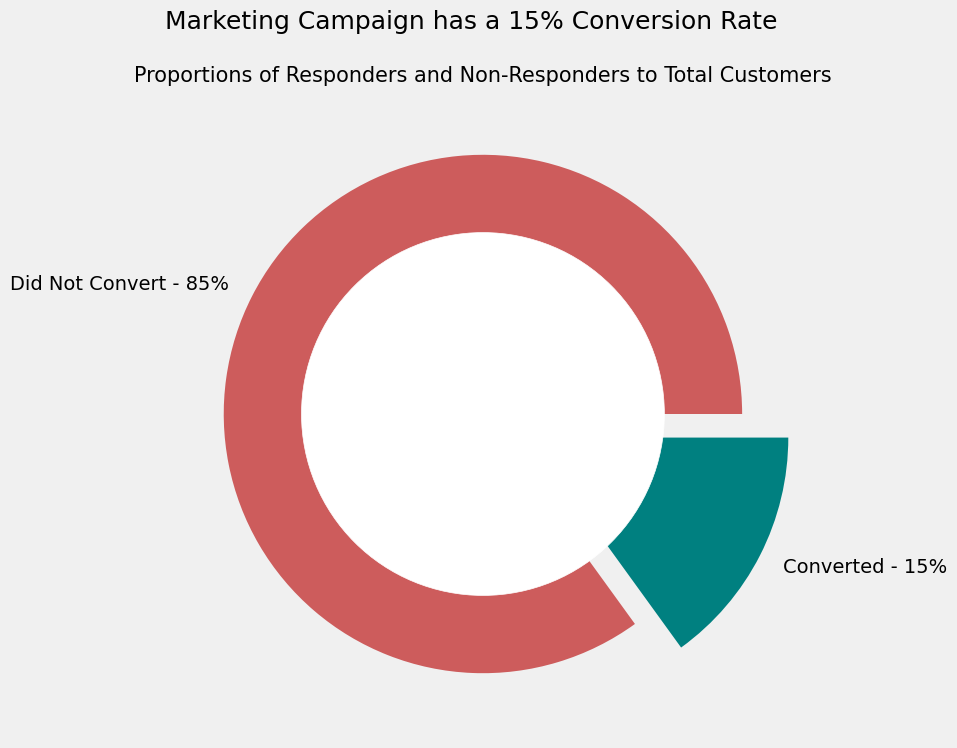

In [50]:
# find number of non-responders vs responders, then create donut plot

response_counts = data.Response.value_counts()

no_response = str(round(response_counts[0]/sum(response_counts)*100)) + '%'
yes_response = str(round(response_counts[1]/sum(response_counts)*100)) + '%'

# donut plot

explode = (0, 0.2)
plt.figure(figsize = (8, 8))
plt.pie(response_counts,
        labels = ['Did Not Convert' + ' - ' + no_response,
                  'Converted' + ' - ' + yes_response],
        explode = explode, 
        colors = ['indianred', 'teal'])

circle = plt.Circle((0,0), 0.7, color='white')

p = plt.gcf()
p.gca().add_artist(circle)

plt.suptitle('Marketing Campaign has a 15% Conversion Rate', size = 18)
plt.title('Proportions of Responders and Non-Responders to Total Customers',
           size = 15)

### Cost Per Acquisition (CPA) and Profitability

The data shows us that the cost to contact a single customer is fixed at $3. We can use this information to calculate how profitable our marketing campaign was


In [51]:
# find profit or loss for each customer targted by campaign

conditions = [data['Response'] == 1, data['Response'] == 0]
outcomes = [8, -3]

data['Profit'] = np.select(conditions, outcomes)

For now we can find a simple total for how profitable our campaign was. Later we will segment profitability by customer characteristics to figure out which of our customers were the most and least valuable

In [52]:
print('The total Profit (+) or Loss (-) of our marketing campaign was {} USD'.format(sum(data['Profit'])))

The total Profit (+) or Loss (-) of our marketing campaign was -2985 USD


Clearly, this marketing campaign was a failure overall, as the business lost $2,985.

Now one of our main aims is to figure out which customers, grouped by characteristics, caused us to lose money (so we reconsider marketing to them in the future) and which customers were profitable (so we can target them more narrowly next time)

## Income

Here I want to find out how conversion and profitability vary with customer Income.

To be able to do this, I will examine the distribution of the Income variable and create appropriate bins, then plot these against the customer responses

Text(0, 0.5, 'Density')

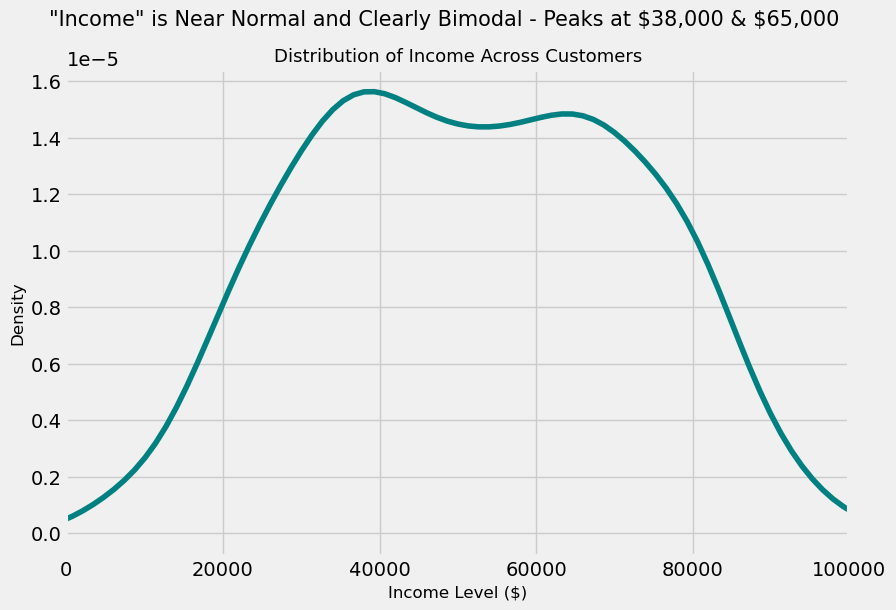

In [53]:
# Let's create a density plot for a smooth graph

plt.figure(figsize = (9, 6))
data['Income'].plot(kind = 'kde', color = 'teal')
plt.xlim([0, 100000])
plt.suptitle('"Income" is Near Normal and Clearly Bimodal - Peaks at \$38,000 & \$65,000', size = 15)
plt.title('Distribution of Income Across Customers', size = 13)
plt.xlabel('Income Level ($)', size = 12)
plt.ylabel('Density', size = 12)

This confirms that the Income variable is Bimodal

### Number and % of Customer Conversions by Income Group

In [54]:
# Create deciles - 10 bins with "Income" variable equally divided

data['Income Deciles'] = pd.qcut(data.Income, q = 10, precision = 0)

The following graph shows the raw number of customer conversions segmented by income deciles (10 bins of customers by income). 

We can clearly see that 

- The greatest number of conversions are isolated to the two highest income deciles


- The fewest number of customers which were targeted by the marketing campaign also belong to the above two deciles

Text(0.5, 0, 'Number of Customers')

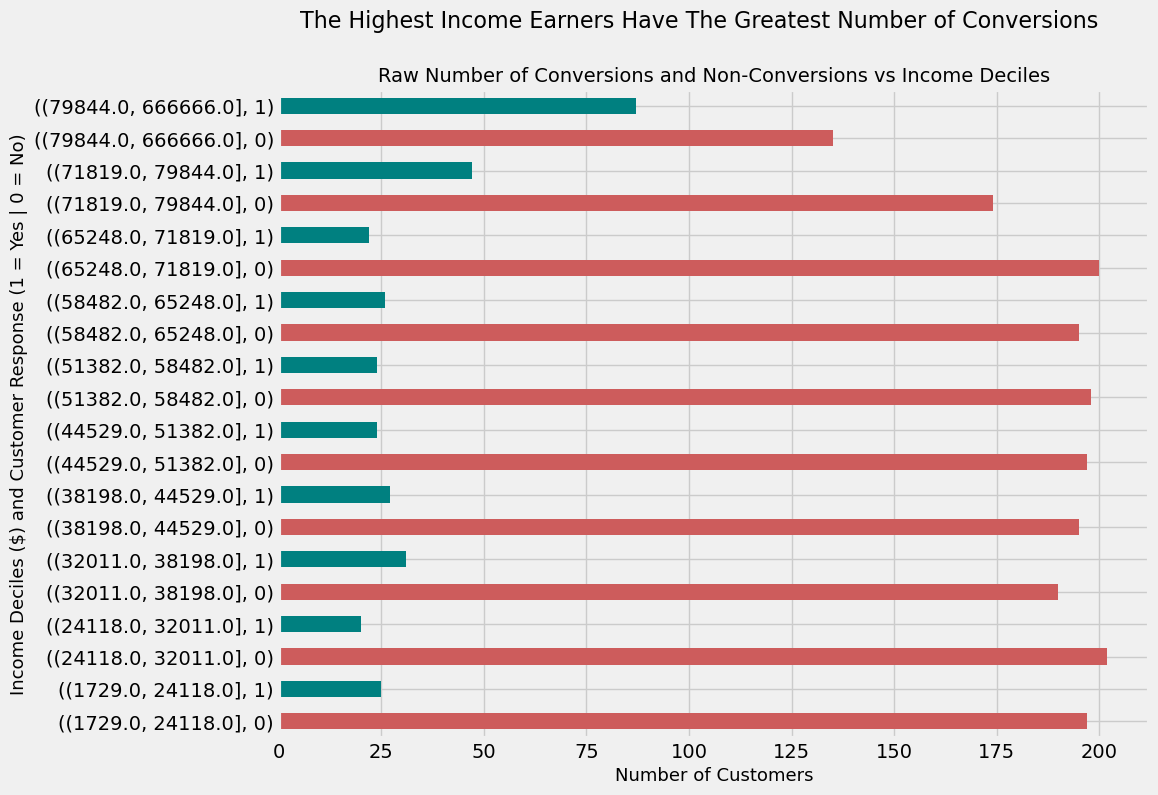

In [55]:
data.groupby('Income Deciles')['Response'].value_counts().plot(kind = 'barh',
                                                               color = ['indianred','teal'],
                                                               figsize = (10, 8))

plt.suptitle('The Highest Income Earners Have The Greatest Number of Conversions', size = 16)
plt.title('Raw Number of Conversions and Non-Conversions vs Income Deciles', size = 14)
plt.ylabel('Income Deciles ($) and Customer Response (1 = Yes | 0 = No)', size = 13)
plt.xlabel('Number of Customers', size = 13)

Above we calculated the raw number of conversions. But a much better measure is to figure out the rate of conversions, which we show below.

We see that with this measure, the highest income groups continue to be the customer segment with the highest conversion

In [56]:
income_vs_conv = pd.crosstab(data['Income Deciles'], data['Response'])

income_vs_conv['Conversion Rate (%)'] = \
              round((income_vs_conv[1]/(income_vs_conv[0] 
              + income_vs_conv[1]))*100, 2)

income_vs_conv.sort_values(by = 'Conversion Rate (%)', ascending = False)

Response,0,1,Conversion Rate (%)
Income Deciles,,,
"(79844.0, 666666.0]",135,87,39.19
"(71819.0, 79844.0]",174,47,21.27
"(32011.0, 38198.0]",190,31,14.03
"(38198.0, 44529.0]",195,27,12.16
"(58482.0, 65248.0]",195,26,11.76
"(1729.0, 24118.0]",197,25,11.26
"(44529.0, 51382.0]",197,24,10.86
"(51382.0, 58482.0]",198,24,10.81
"(65248.0, 71819.0]",200,22,9.91


### Marketing Campaign Profitability by Income Deciles

Now that we have looked at raw conversions and conversion rates, let's assess the profitability of each customer income segment 

Text(0.5, 0, 'Profit/Loss ($)')

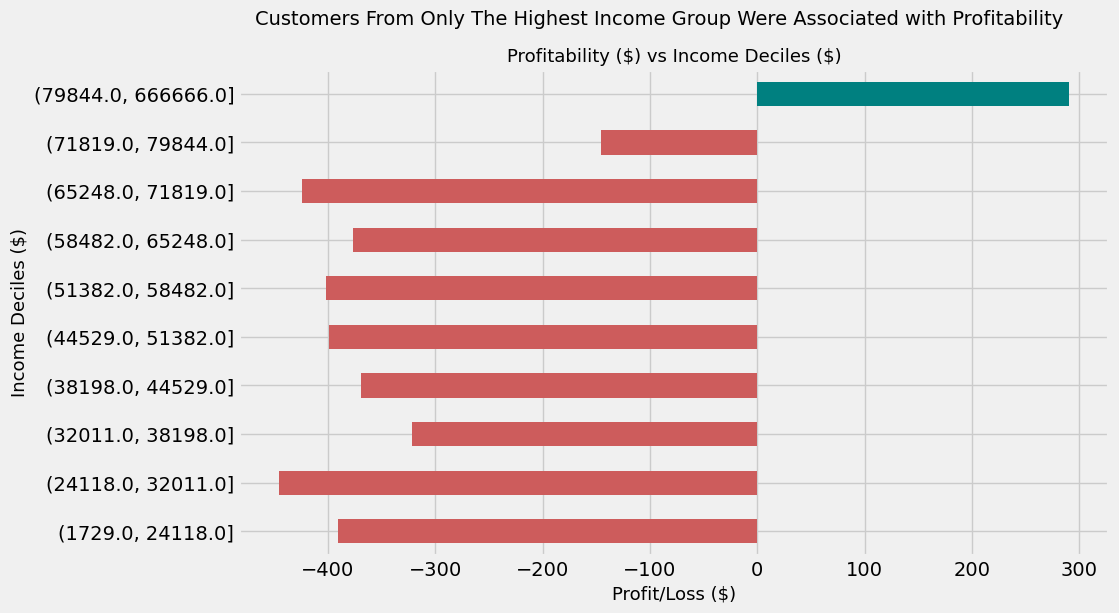

In [57]:
# assign 'indianred' colour to loss-making segments
# and 'teal' to profitable segments

LC = 'indianred'
PC = 'teal'

data.groupby('Income Deciles')['Profit'].sum().plot(kind = 'barh',
                                                    color = [LC, LC,
                                                             LC, LC,
                                                             LC, LC,
                                                             LC, LC,
                                                             LC, PC],
                                                    figsize = (10, 6))


plt.suptitle("""Customers From Only The Highest Income Group Were Associated with Profitability""",
              size = 14)

plt.title('Profitability (\\$) vs Income Deciles (\\$)', size = 13)

plt.ylabel('Income Deciles ($)', size = 13)
plt.xlabel('Profit/Loss ($)', size = 13)

The marketing campaign resulted in losses for each and every single customer group except the highest incoming earning group when segmented by Income level. 

This latter group were responsible for \\$291 in profit. Conversely, the greatest loss was incurred in the second-to-lowest decile by Income which was approximately $450

### Takeaway

This analysis seems to imply that the marketing campaign appeals the most to high income groups. They have the greatest conversion and, as a result, were the only profitable income group in the context of the marketing campaign.

If we run a future marketing campaign that is similar to this one, it could be a good idea to target high-income customers only, specifically those earning above $79,884 per year

## Age and Education

Next I want to figure out the conversion rates and market campaign profitability when customers are segmented by Age and Education

Text(0, 0.5, 'Frequency')

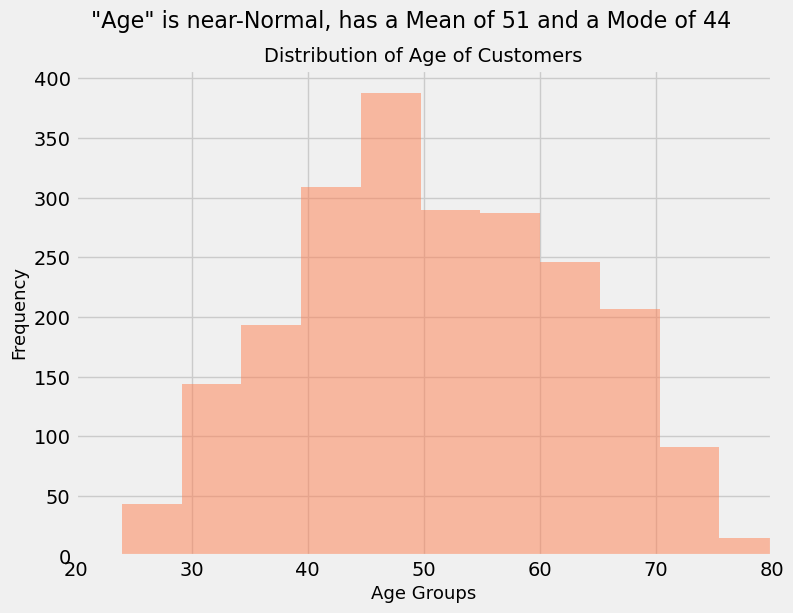

In [58]:

# Create "Age" variable and plot histogram

data['Age'] = 2020 - data['Year_Birth']
data['Age'].hist(bins = 20, color = 'coral',
                 alpha = 0.5, figsize = (8, 6))
plt.xlim([20, 80])

plt.suptitle('"Age" is near-Normal, has a Mean of 51 and a Mode of 44', size = 16)
plt.title('Distribution of Age of Customers', size = 14)
plt.xlabel('Age Groups', size = 13)
plt.ylabel('Frequency', size = 13)

### Conversion & Profitability by Age Group

In [59]:
### 2.31) Conversion & Profitability by Age Group
# create Age bins

# Youngest customer is 24 years old

data['Age Bins'] = pd.cut(data['Age'],
                          bins = [24, 30, 40, 
                                  50, 60, 70,
                                  80, 120]) 

Text(0.5, 1.0, 'Conversion Percentage by Age Group')

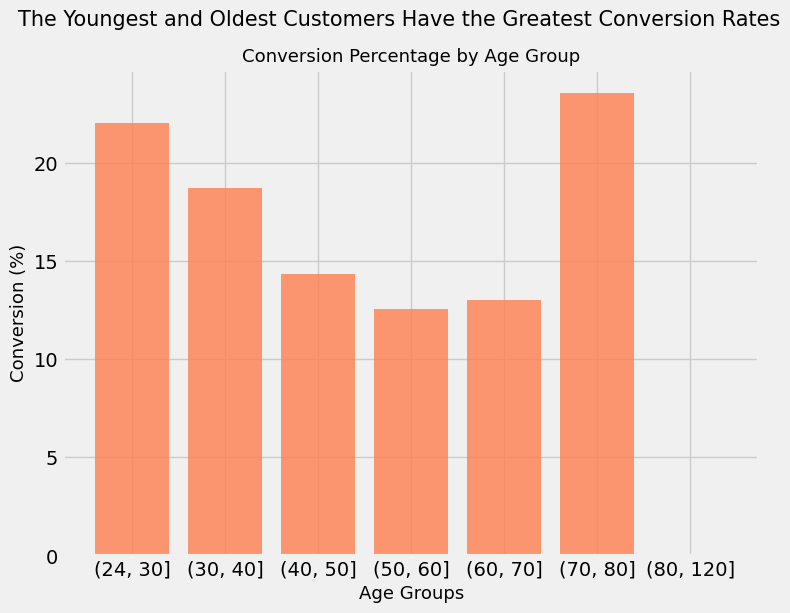

In [60]:
# plot conversion rates against age groups

age_conv_rate = pd.crosstab(data['Age Bins'], data['Response'])

age_conv_rate['Conversion %'] = \
              round((age_conv_rate[1]/(age_conv_rate[0]+age_conv_rate[1]))*100, 2)

age_conv_rate.reset_index(inplace = True)
age_conv_rate['Age Bins'] = age_conv_rate['Age Bins'].astype(str)

plt.figure(figsize = (8, 6))
plt.bar(age_conv_rate['Age Bins'],
        age_conv_rate['Conversion %'],
        color = 'Coral',
        alpha = 0.8)

plt.xlabel('Age Groups', size = 13)
plt.ylabel('Conversion (%)', size = 13)
plt.suptitle('The Youngest and Oldest Customers Have the Greatest Conversion Rates', size = 15)

plt.title('Conversion Percentage by Age Group', size = 13)

Customers with ages in the intervals of 24-30 and 70-80 have the greatest conversion rates. For every 50 customers targeted with the marketing campaign in these age groups, more than 10 customers convert.

Conversely, middle-aged customers (those between 40 and 70 yeaes of age) have the worst conversion rate (between 12% and 14%)

In [61]:
youngest_and_oldest_customers = \
data.groupby('Age Bins')['ID'].count()[0] 
+ data.groupby('Age Bins')['ID'].count()[5]

print('The total number of customers targeted belonging '
      'to the oldest and youngest age groups is {}'.format(youngest_and_oldest_customers))

KeyError: 0

In [ ]:
# Inspect the result of groupby
print(data.groupby('Age Bins')['ID'].count())

# Access counts using keys or indices
youngest_and_oldest_customers = \
data.groupby('Age Bins')['ID'].count().iloc[0] + \
data.groupby('Age Bins')['ID'].count().iloc[-1]

print('The total number of customers targeted belonging '
      'to the oldest and youngest age groups is {}'.format(youngest_and_oldest_customers))


Out of the total number of 2216 customers targeted in this ad campaign, 165 or about 7.5% belong to the age groups with the greatest conversion rates.

Now, we need to be careful with the conclusions we extract from this analysis. Larger sample sizes generally lead to more valid and accurate estimates. It is quite possible that if we were to target a larger sample size of only the oldest and youngest customers that the conversion percentages may drop from their current levels of > 20%, as the larger sample size will be more indicative of reality

Another way of saying this is that the youngest and oldest age groups might have such high conversion rates *because* there are very few of them compared to the whole customer base, and the small sample size might not be indicative of the ground truth


----

Now let's look at profitability

In [ ]:
data.groupby('Age Bins')['Profit'].sum().plot(color = 'coral',
                                              figsize = (10, 6))
plt.ylabel('Loss ($)', size = 12)
plt.xlabel('Age Groups', size = 12)
plt.suptitle('Middle Aged Customers Are Associated with the Greatest Monetary Loss',
             size = 15)
plt.title('Marketing Campaign Profitability by Age Group', size = 13)

### Takeaway


While we expected the groups with the worst conversion rates to not be profitable (middle aged customers), it is surprising to find that not a single group of customers, when segment by Age, proved to be profitable in our most recent Marketing Campaign.

Customers between 40 and 50 years have an associated loss of more than $1000. Interestingly, it is this same age group that has the greatest representation by raw numbers in the overall number of customers

What does this tell us in combination with the graph showing conversions? **It tells us that even in those Age Groups where the conversion rate is the highest, it is still not high enough for the marketing campaign to be profitable**

Therefore, targeting customers by age does not seem like a good idea for future marketing campaigns

###  Education

In [ ]:
### 2.32) Education
# find sum of profit per value of "Education"

education_vs_profit = data.groupby('Education')['Profit'].sum()

# create lollipop chart

plt.figure(figsize = (10, 6))

my_range = range(1,len(education_vs_profit.index)+1)
plt.hlines(y = education_vs_profit.index,
           xmin = 0 ,
           xmax = education_vs_profit,
           color='indianred')

plt.plot(education_vs_profit, education_vs_profit.index,
         "o", color = 'black')

plt.xticks(size = 10)
plt.yticks(size = 10)
plt.suptitle('Customers of All Levels of Education are Associated with Losses',
             size = 14)

plt.title('Profitability by Education Level', size = 12)
plt.ylabel('Highest Education Achieved', size = 12)
plt.xlabel('Loss ($)', size = 12)

### Takeaway

Much like the case with Age Groups, the "middle value" of Education, "Graduation" was related to the greatest loss incurred, reaching nearly -$1750. Moreover, all customers when segmented by Education are associated with losses.

These findings suggest that future marketing campaigns should not target or segment customers on the basis of this characteristic.

## Living Arrangements: Individual vs With Family

Let's consider:

- "Individuals" to be customers who are Single and have no children, and therefore do not live with them


- "With Family" to be customers who are either Single or Married but have at least 1 child or 1 teen living in the same house

In [ ]:
# create two dataframes to capture one group each

individuals = data.loc[(data['Marital_Status'] == 'Single') &
                       (data['Kidhome'] == 0) &
                       (data['Teenhome'] == 0)]

families = data.loc[(data['Kidhome'] == 1) |
                    (data['Teenhome'] == 1)]

# create a Series with the sum of Profit for above dataframes

ind_vs_family_profit = pd.Series([individuals.groupby('ID')['Profit'].sum().sum(),
                                  families.groupby('ID')['Profit'].sum().sum()],
                                  index = ['Individual', 'With Family'])

# plot

ind_vs_family_profit.plot(kind = 'barh', color = ['#004643', '#6A2E35'],
                          figsize = (11, 6))
plt.suptitle('Customers Who Live Alone Are Profitable While Those Who Live with Families Incur Heavy Losses',
              size = 16)
plt.title('Total Profits ($) Per Customer by Living Arrangements',
          size = 14)
plt.xlabel('Profit/Loss ($)', size = 11)
plt.ylabel('Living Arrangement', size = 11)
plt.xticks(size = 10)
plt.yticks(size = 10)

In [ ]:
# create two dataframes to capture one group each

individuals = data.loc[(data['Marital_Status'] == 'Single') &
                       (data['Kidhome'] == 0) &
                       (data['Teenhome'] == 0)]

families = data.loc[(data['Kidhome'] == 1) |
                    (data['Teenhome'] == 1)]

# create a Series with the sum of Profit for above dataframes

ind_vs_family_profit = pd.Series([individuals.groupby('ID')['Profit'].sum().sum(),
                                  families.groupby('ID')['Profit'].sum().sum()],
                                  index = ['Individual', 'With Family'])

# plot

ind_vs_family_profit.plot(kind = 'barh', color = ['#004643', '#6A2E35'],
                          figsize = (11, 6))
plt.suptitle('Customers Who Live Alone Are Profitable While Those Who Live with Families Incur Heavy Losses',
              size = 16)
plt.title('Total Profits ($) Per Customer by Living Arrangements',
          size = 14)
plt.xlabel('Profit/Loss ($)', size = 11)
plt.ylabel('Living Arrangement', size = 11)
plt.xticks(size = 10)
plt.yticks(size = 10)

In [ ]:
# plot conversion percentage 

ind_vs_family_conv = pd.Series([round((individuals.Response.sum()/len(individuals))*100, 2),
                                round((families.Response.sum()/len(families))*100, 2)],
                                index = ['Individuals', 'With Family'])

ind_vs_family_conv.plot(kind = 'bar', color = ['#004643', '#6A2E35'],
                        figsize = (9, 7))
plt.suptitle('Conversion Rate of "Individuals" is Nearly Quadruple the Rate of "With Family"',
             size = 15)
plt.title('Conversion Rates (%) by Living Arrangements',
          size = 13)
plt.xlabel('Living Arrangement', size = 11)
plt.ylabel('Conversion Rate (%)', size = 11)
plt.xticks(size = 10)
plt.yticks(size = 10)

With nearly 4 times the conversion rate of customers who are considered to live "With Family", customers who live alone ("Individuals") are unsurprisingly associated with profitability (albeit a small profit) while the "With Family" group is associated with a loss of $2,700

---

### Takeaway

So far we see that when we market to customers with the following characteristics, the marketing campaign is effective (as it is profitable):

- High-income customers, specifically those earning more than $79,000 annually


- Customers who live alone


This seems to imply that the marketing campaign is effective with wealthy bachelors and bachelorettes

## Date of First Purchase (with some caveats)

I wonder if there is any relationship between the time elapsed between the date when a customer made their first purchase and the response rate. This isn't the best pair of measures to compare, but unfortunately we do not have other useful time-related data. This could be on, for example, the time elapsed since the *last* purchase, not the first one. So we will make do with what we have.

It is difficult to come up with a hypothesis before this analysis. For example, if we had data on every purchase a customer has made within a given timeframe, we could hypothesize that customers who made purchases with greater frequency in the last X number of days would be significantly more likely to convert due to the marketing campaign than customers who bought less frequently.

But since we do not have that data, let's just explore the conversion rates segmented by time elapsed since first purchase in months

The last date in the data is 2014-06-29, so I will consider 2014-06-30 to be "today"

In [64]:
# convert date of joining column to datetime format

data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])

# Find the number of days elapsed since first purchase

data['Days Elapsed'] = datetime(2014, 6, 30) - data['Dt_Customer']
data['Days Elapsed'] = data['Days Elapsed'].dt.days

In [65]:
# create bins

myBins = np.linspace(min(data['Days Elapsed']),
                     max(data['Days Elapsed']), 
                     num = 23, endpoint = True)

# create labels

labels = []

for i in range(22):
    time_elapsed = str(i) + ' Months Ago'
    labels.append(time_elapsed)
    
# add bins to dataframe

data['Time Elapsed Bins'] = pd.cut(data['Days Elapsed'],
                                   myBins, labels = labels,
                                   include_lowest = True)

In [66]:
# create crosstab of labelled bins and Response

time_elapsed_conv_rate = pd.crosstab(data['Time Elapsed Bins'], data['Response'])
time_elapsed_conv_rate

time_elapsed_conv_rate['Conversion %'] = round((time_elapsed_conv_rate[1]/
                                               (time_elapsed_conv_rate[0] +
                                                time_elapsed_conv_rate[1]))*100, 2)
time_elapsed_conv_rate.reset_index(inplace = True)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

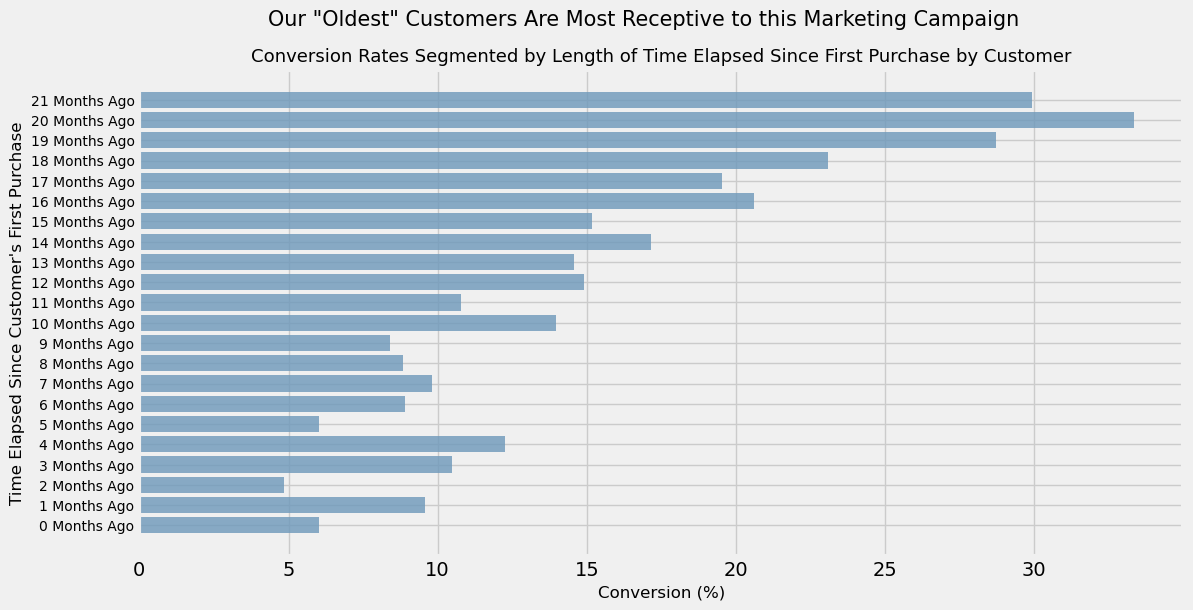

In [67]:
# plot crosstab

plt.figure(figsize = (12, 6))
plt.barh(time_elapsed_conv_rate['Time Elapsed Bins'],
        time_elapsed_conv_rate['Conversion %'],
        color = '#6D98BA',
        alpha = 0.8)

plt.suptitle('Our "Oldest" Customers Are Most Receptive to this Marketing Campaign', size = 15)
plt.title('Conversion Rates Segmented by Length of Time Elapsed Since First Purchase by Customer', size = 13)
plt.ylabel('Time Elapsed Since Customer\'s First Purchase', size = 12)
plt.xlabel('Conversion (%)', size = 12)
plt.yticks(size = 10)

### Takeaway

It seems to be the case that there is some phenomenon occurring whereby customers who were acquired a long time ago (alternatively, our oldest customers) have a much greater rate of conversion than those customers who were acquired recently.

- Perhaps our oldest customers know more about the product/service we're offering and so they are more liable to buy


- Perhaps brand loyalty has come into play; older customers who have remained active with our company are more likely to be more loyal than newly acquired customers. Otherwise, they would not have converted. Similarly, we can say that not enough time has elapsed for the newly acquired customers to feel a sense of loyalty to our company


- Perhaps there are other changes we made in the business where things are done differently to when they were done previously. This can include many things: a change in our branding, customer service, product and more. It is difficult to isolate this idea but it can be the basis for a future experiment


Regardless, the data suggests that it is a good idea to target our oldest customers with marketing campaigns similae to this one

# Clustering Analysis

In [68]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Profit', 'Income Deciles', 'Age', 'Age Bins', 'Days Elapsed',
       'Time Elapsed Bins'],
      dtype='object')

In [69]:
data_clustering = data.drop(['ID', 'Year_Birth', 'Dt_Customer',
                             'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                             'AcceptedCmp4', 'AcceptedCmp5', 'Z_CostContact',
                             'Z_Revenue', 'Income Deciles', 'Age Bins',
                             'Time Elapsed Bins', 'Profit'], axis = 1)

In [70]:
# create dummies for "marital_status" variable, then concatenate to dataframe

marital_status_dummies = pd.get_dummies(data['Marital_Status'])
data_clustering = pd.concat([data_clustering, marital_status_dummies], axis = 1)

# and drop original "marital_status" variable

data_clustering.drop('Marital_Status', axis = 1, inplace = True)

data_clustering.drop(['Absurd', 'YOLO'], axis = 1, inplace = True) # drop irrelevant dummies

In [71]:
# do the same as above for "Education" variable

education_dummies = pd.get_dummies(data['Education'])
data_clustering = pd.concat([data_clustering, education_dummies], axis = 1)
data_clustering.drop('Education', axis = 1, inplace = True)

# Ensure I got the following right

In [72]:
# place outcome variable, Response, at the end of the dataframe

response_variable = data_clustering['Response']
data_clustering.drop('Response', axis = 1, inplace = True)
data_clustering['Response'] = response_variable

## Correlation heatmap

<AxesSubplot:>

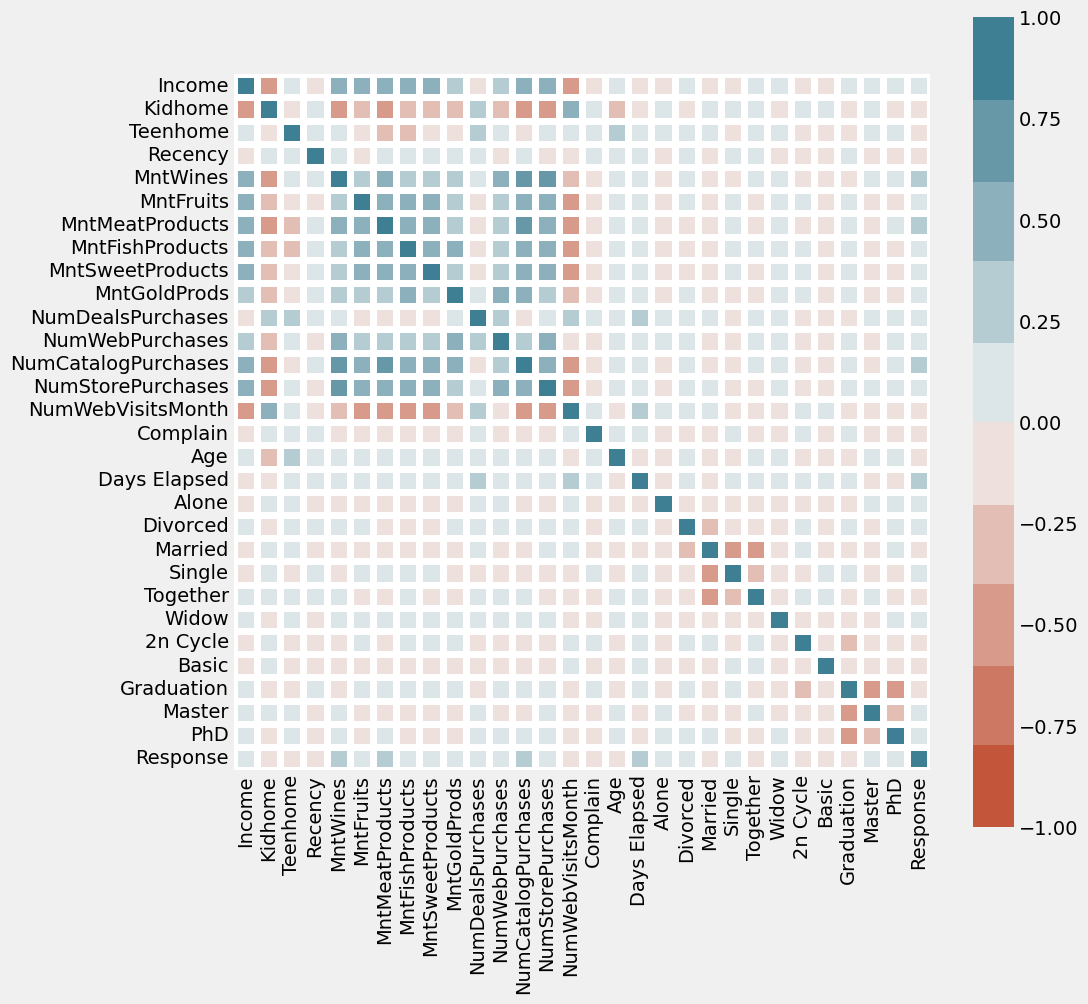

In [73]:
corr = data_clustering.corr()

plt.figure(figsize = (10, 10))

sns.heatmap(corr,
            vmin = -1, vmax = 1, center = 0, 
            cmap = sns.diverging_palette(20, 220, n = 10),
            square = True, linewidths = 5)

We are only interested in the last column. We see that even the features with the greatest correlation with the outcome (Response) variable have only a weak-to-moderate magnitude. But these are the best features we have, so we will have to make do.

Overall, I am selecting only those features where the absolute magnitude of correlation coefficient is > 0.12.

This is a fairly arbitrary cut-off that I have chosen by inspecting the correlation coefficients of the whole dataset. My reasoning is that according to this criterion, we choose about 8 features and drop the rest. 

If this criterion were harsher, we would have too few features to use. If it were more lax, we would be including features that have even worse correlation or no correlation at all with the outcome variable "Response".

In [74]:
data_clustering.corr()['Response']

Income                 0.133047
Kidhome               -0.077909
Teenhome              -0.153901
Recency               -0.199766
MntWines               0.246299
MntFruits              0.122443
MntMeatProducts        0.237746
MntFishProducts        0.108145
MntSweetProducts       0.116170
MntGoldProds           0.140332
NumDealsPurchases      0.003451
NumWebPurchases        0.151431
NumCatalogPurchases    0.219914
NumStorePurchases      0.036241
NumWebVisitsMonth     -0.002209
Complain              -0.002029
Age                   -0.023692
Days Elapsed           0.196479
Alone                  0.018862
Divorced               0.054189
Married               -0.079821
Single                 0.108726
Together              -0.075293
Widow                  0.045656
2n Cycle              -0.035496
Basic                 -0.050080
Graduation            -0.039660
Master                 0.003919
PhD                    0.087979
Response               1.000000
Name: Response, dtype: float64

In [75]:
relevant_data = data_clustering.loc[:, ['Income', 'Teenhome', 'MntWines',
                                        'MntMeatProducts','MntGoldProds',
                                        'NumCatalogPurchases', 'NumWebPurchases',
                                        'Days Elapsed', 'Response']]

## Scale data

We need to scale our data. We use MinMaxScaler instead of StandardScaler because the distribution of values in the selected features is not normal

In [76]:
# create a copy of relevant dataframe

data_clustering_copy = relevant_data.copy()

scaler = MinMaxScaler() 
data_scaled = scaler.fit_transform(data_clustering_copy)

# convert scaled data back into dataframe

data_clustering_copy_scaled = pd.DataFrame(data_scaled)

# re-assign names

column_names = list(data_clustering_copy.columns)

data_clustering_copy_scaled.columns = column_names

## Fit K-Means Clustering Algorithm

### Find optimal number of clusters (elbow method)

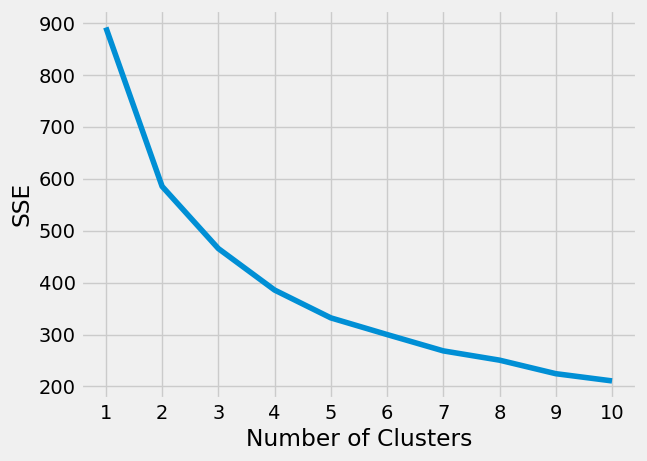

In [77]:
# find sum of squared error per number of clusters

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_clustering_copy_scaled)
    sse.append(kmeans.inertia_)
    
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

By eye, it seems 4 clusters is the optimal choice

In [78]:
# fit and transform data to create 4 clusters

km = KMeans(n_clusters = 4)
km.fit(data_clustering_copy_scaled)

# predict clusters for each row in original dataframe
# with non-scaled values

data_clustering_copy['clusters'] = km.labels_

Now we wrangle data in a way which allows us to segment "Response" outcome and other variable based on the different clusters that datapoints are assigned to

In [79]:
data_clustering_copy["cluster_0"] = data_clustering_copy.clusters == 0
data_clustering_copy["cluster_1"] = data_clustering_copy.clusters == 1
data_clustering_copy["cluster_2"] = data_clustering_copy.clusters == 2
data_clustering_copy["cluster_3"] = data_clustering_copy.clusters == 3

In [80]:
# find how many customers converted in each cluster

data_clustering_copy.groupby("clusters")['Response'].sum()

clusters
0      0
1      0
2      0
3    333
Name: Response, dtype: int64

All 333 customers that converted in the whole dataset belong to cluster 2. This is really interesting; it implies that the traits of customers in this cluster are significantly correlated with a higher likelihood of conversion.

I want to reiterate this finding a different way because it is quite important: **every customer who converted was in Cluster 2, but not all customers in Cluster 2 converted**.

The next step is to find out what these characteristics are because based off them, we will be able to better isolate relevant customers for our next marketing campaign and make this campaign more targeted. As a result, the next marketing campaign should see much greater conversion and profitability overall

In [81]:
data_clustering_copy.groupby('clusters').mean()

,Income,Teenhome,MntWines,MntMeatProducts,MntGoldProds,NumCatalogPurchases,NumWebPurchases,Days Elapsed,Response,cluster_0,cluster_1,cluster_2,cluster_3
clusters,,,,,,,,,,,,,
0,50423.077966,1.057627,182.715254,68.957627,24.947458,1.608475,3.523729,220.813559,0.0,1.0,0.0,0.0,0.0
1,46567.036486,0.000000,193.122973,153.183784,33.863514,2.172973,3.018919,269.513514,0.0,0.0,1.0,0.0,0.0
2,56999.754069,0.712477,466.544304,213.739602,67.363472,3.549729,5.517179,553.987342,0.0,0.0,0.0,1.0,0.0
3,60209.675676,0.306306,502.615616,293.765766,61.252252,4.201201,5.072072,449.081081,1.0,0.0,0.0,0.0,1.0


### Takeaway

Customers in cluster 1:

- Have the greatest average income at $60209


- Have 3 teens per 10 homes on average. So while these customers are not completely teen-less, they tend to live with   fewer teens on average than customers in other clusters [specifically Cluster 3 (about 7 teens per 10 homes) and Cluster 2 (more than 1 teen per home)]


- Spend the most on wine per month at $502


- Spend the most on meat products per month at $294


- Spend the *second most* on gold products per month at \\$61, with customers in Cluster 3 spending the most (\\$66)


- Make the most purchases through catalogues at 4.2. The frequency of purchase is not listed in the meta information of the dataset, but 
  it is reasonable to assume in the absence of information that points otherwise that this frequency is monthly
  
  
- Make the most purchases through the Web at 5. Again, this is assuming a monthly figure


- Are usually among our oldest customers (in terms of how long they've been with the company, not their Age), with an   average of 449 days since their first purchase. However, they are not *the* oldest group of customers. Those belong   to cluster 3 which, it should be reiterated, did not have a single customer convert